# Práctica 2 - CNN para clasificar imágenes de Rayos X de neumonía - Lab 2
## Preparación de entorno
#### Instalar las librerías

In [15]:
"""Instalar pytorch con cuda"""
#%pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

'Instalar pytorch con cuda'

#### Importar librerías de código

In [16]:
import torch # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import torchvision # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
from torchvision import datasets, transforms # type: ignore
from torch.utils.data import DataLoader, random_split # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## CNN SetUp




### Preparación Dataset
En primer lugar, establecemos las rutas de los datasets

In [17]:
def preparar_dataset(ruta_dataset):
    ruta_train = os.path.join(ruta_dataset, "train")
    ruta_test = os.path.join(ruta_dataset, "test")

    if not os.path.exists(ruta_train) or not os.path.exists(ruta_test):
        print("Error al encontrar las rutas")
    else:
        print("Rutas cargadas correctamente")

    subcarpetas = [d for d in os.listdir(ruta_train) if os.path.isdir(os.path.join(ruta_train, d))]
    num_clases = len(subcarpetas)

    return ruta_train, ruta_test, subcarpetas, num_clases

ruta_train1, ruta_test1, subcarpetas1, num_clases1 = preparar_dataset(".\data\chest_xray")

Rutas cargadas correctamente


<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
C:\Users\david\AppData\Local\Temp\ipykernel_27492\1830357528.py:15: SyntaxWarning: invalid escape sequence '\d'
  ruta_train1, ruta_test1, subcarpetas1, num_clases1 = preparar_dataset(".\data\chest_xray")


Una vez tenemos las rutas establecidas, podemos proceder con el preprocesamiento del dataset. Lo primero que haremos será **normalizar** las imagenes. Para ello, convertiremos las imágenes a tensores (lo que sería convertirlo a matriz), y una vez convertido a tensor, las normalizaremos. Además, como las *etiquetas* de las imagenes vienen definidas por la carpeta en la que están contenidas, utilizaremos el método ImageFolders, el cual asignará la etiqueta a cada imagen **basandose en el nombre de la carpeta**.

In [18]:
def normalizar_dataset(ruta_train, ruta_test):
    transformer = transforms.Compose([
        # Convertimos las imágenes a escala de grises (1 canal), y redimensionamos a 100x100 píxeles
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    train_dataset = datasets.ImageFolder(root=ruta_train, transform=transformer)
    test_dataset = datasets.ImageFolder(root=ruta_test, transform=transformer)

    val_size = int(0.2 * len(train_dataset))
    train_size = len(train_dataset) - val_size

    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

    return train_subset, val_subset, test_dataset

train_subset1, val_subset1, test_dataset1 = normalizar_dataset(ruta_train1, ruta_test1)


##### Cuestión 1
**Enunciado:**

*Explica las funciones y el algoritmo para convertirlas a matrices. ¿Qué es cada matriz?
¿Qué tamaños tienen las imágenes? ¿Has normalizado? ¿Cómo y por qué?*

**Solución:**

Para que nuestra red neuronal pueda trabajar con imágenes en blanco y negro, debemos convertirlas a matrices.

A diferencia de las imágenes RGB, esta matriz sólo tendrá una dimensión, ya que carece de color, por lo que se podría decir que estamos trabajando con una escala de grises.

Por lo tanto, en este caso tendremos una matriz 100x100 de una dimensión (1, 100, 100).

La normalización tiene media de `0.5` y una desviación típica de `0.5`, lo que transforma los valores del rango `[0, 1]` al rango `[-1, 1]`, centrado en el 0, para mejorar la estabilidad y velocidad del entrenamiento.

Prosigamos con el ajuste de los hiperparámetros:

In [19]:
batch_size = 16
epochs = 5
learning_rate = 0.001

hidden_size = 128
out_channels = 4
conv_kernel_size = 3
pool_kernel_size = 2


A continuación, crearemos los DataLoaders, una estructura de pytorch que nos permitirá dividir los datasets por *lotes*, con el fin de tener un entrenamiento más eficiente.

In [20]:
def DataLoaders(train_subset, val_subset, test_dataset, batch_size):
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

train_loader1, val_loader1, test_loader1 = DataLoaders(train_subset1, val_subset1, test_dataset1, batch_size)

### Implementación

Una vez hemos realizado el preprocesamiento de nuestro dataset, podemos proceder con la arquitectura de nuestra CNN.

#### Arquitectura de la CNN
La red convolucional tiene la siguiente composición:
- **Entrada:** imágenes en escala de grises, redimensionadas a `100x100`
- **Capa convolucional 1:** `Conv2D(1 → 4 filtros)` con kernel `3x3`, padding=1 + `ReLU` + `MaxPool2D(2x2)`
- **Capa convolucional 2:** `Conv2D(4 → 8)` con kernel `3x3`, padding=1 + `ReLU` + `MaxPool2D(2x2)`
- **Capa convolucional 3:** `Conv2D(8 → 16)` con kernel `3x3`, padding=1 + `ReLU` + `MaxPool2D(2x2)`
- **Capa densa:** `Linear(16×12×12 → 128)` + `ReLU`
- **Salida:** `Linear(128 → Número de clases)`
- **Función de activación final:** implícita con `CrossEntropyLoss` (usa softmax internamente)

Utilizamos RELU como función de activación, ya que es muy rápida de calcular y evita el problema del vanishing gradient. Además es ideal para activar las características extraídas por los filtros.

In [21]:
class CNN_PNEUMO(nn.Module):
    def __init__(self, num_clases):
        super(CNN_PNEUMO, self).__init__()

        self.capa1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=conv_kernel_size, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2, padding=0)

        self.capa2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels*2, kernel_size=conv_kernel_size, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2, padding=0)

        self.capa3 = nn.Conv2d(in_channels=out_channels*2, out_channels=out_channels*4, kernel_size=conv_kernel_size, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2, padding=0)

        self.fc1 = nn.Linear(out_channels*4 * 12 * 12, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_clases)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.capa1(x)))
        x = self.pool2(self.relu(self.capa2(x)))
        x = self.pool3(self.relu(self.capa3(x)))

        x = x.view(-1, out_channels*4 * 12 * 12)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Se entrenará el modelo con los siguientes parámetros:

- **Optimizador:** `Adam`
- **Función de pérdida:** `CrossEntropyLoss`
- **Criterio de parada:** `loss ≤ 0.2`
- **Número máximo de epochs:** `10`
- **Batch size:** `32`

El optimizador Adam es ideal ya que es robusto y suele converger más rápidamente que otros optimizadores como por ejemplo SGD.
Además, no exige demasiada configuración, lo que simplifica su implementación.

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_sano_enfermo = CNN_PNEUMO(num_clases1).to(device)

criterio = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer1 = optim.Adam(model_sano_enfermo.parameters(), lr=learning_rate)

torch.cuda.empty_cache()
print(f'Modelo en: {device}')

Modelo en: cuda


Después, definimos la función de evaluación, para monitorizar la evolución del modelo en base a las dos tareas propuestas.

In [23]:
def validacion(model, val_loader, criterio):
    model.eval() 
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterio(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    return val_loss / len(val_loader), val_accuracy 

###Entrenamiento tarea 1 (tipos de pneumonía)
Procedemos a entrenar la red con el dataset de entrenamiento para la tarea de distinguir entre diferentes tipos de pneumonía.

In [24]:
def entrenamiento(model, optimizer, train_loader, val_loader):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterio(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        #if epoch_loss < 0.2:
        #    print(f"Aprendizaje completado. {epoch_loss:.4f} < 0.2")
        #    break
        
        val_loss, val_accuracy = validacion(model, val_loader, criterio)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
    torch.cuda.empty_cache()
    return model, train_losses, train_accuracies, val_accuracies, val_losses 

In [25]:

print("\nClasificar entre Sano y Enfermo")
model_sano_enfermo, train_losses1, train_accuracies1, val_accuracies1, val_losses1  = entrenamiento(model_sano_enfermo, optimizer1, train_loader1, val_loader1)

torch.save(model_sano_enfermo.state_dict(), 'modelo_sano_enfermo.pth')

print("Modelos guardados")


Clasificar entre Sano y Enfermo
Epoch [1/5], Loss: 0.2739, Accuracy: 88.57%
Epoch [2/5], Loss: 0.1365, Accuracy: 94.58%
Epoch [3/5], Loss: 0.1118, Accuracy: 95.57%
Epoch [4/5], Loss: 0.0919, Accuracy: 96.19%
Epoch [5/5], Loss: 0.0769, Accuracy: 97.27%
Modelos guardados


##Gráficos de entrenamiento


Entrenamiento para distinguir entre Sano y Enfermo



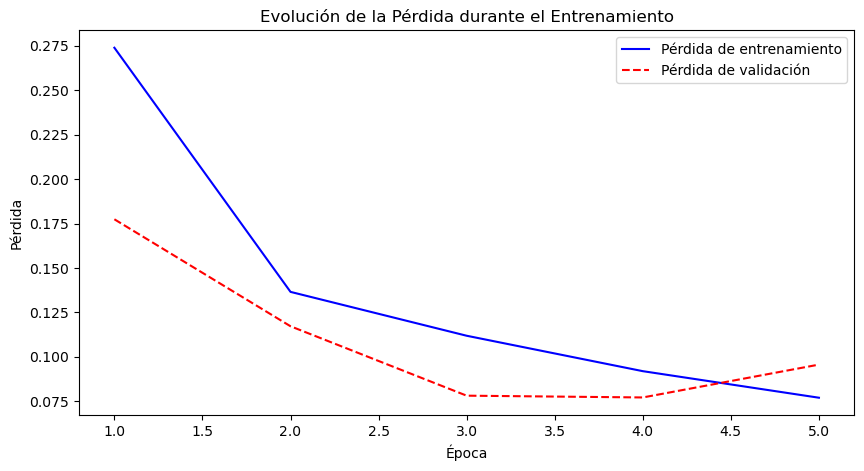

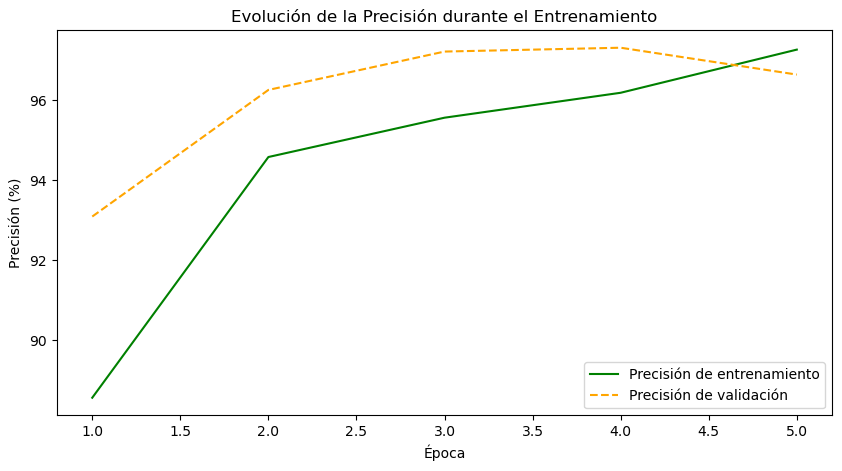

NameError: name 'model_tipos_pneumo' is not defined

In [ ]:
def graficar_entrenamiento(model, train_losses, train_accuracies, val_accuracies, val_losses ):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Pérdida de entrenamiento", color='blue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Pérdida de validación", color='red', linestyle='dashed')
    plt.title("Evolución de la Pérdida durante el Entrenamiento")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Precisión de entrenamiento", color='green')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Precisión de validación", color='orange', linestyle='dashed')
    plt.title("Evolución de la Precisión durante el Entrenamiento")
    plt.xlabel("Época")
    plt.ylabel("Precisión (%)")
    plt.legend()
    plt.show()

print("\nEntrenamiento para distinguir entre Sano y Enfermo\n")
graficar_entrenamiento(model_sano_enfermo, train_losses1, train_accuracies1, val_accuracies1, val_losses1)


#### Cuestión 3

Para abordar esta pregunta, debemos comparar los resultados obtenidos por cada uno de los modelos.
Graficaremos estos resultados para observar cual de los dos tiene la mejor accuracy y la menor pérdida. Además, podemos extraer las matrices de confusión de cada modelo para profundizar aún más.

A la hora de realizar dos clasificaciones diferentes, existía la posibilidad de usar un solo modelo que tuviese dos salidas en vez de una, distinguiendo entre tareas. Este modelo tendría dos capas de salida en vez de una sola `self.fc2`. Este método, que a priori parece más eficiente en cuanto a complejidad de código y recursos, se descartó debido a los siguientes motivos:
- Disponer de un modelo para cada clasificación provoca que cada modelo pueda especializarse mejor a la tarea asignada. Ambos modelos utilian la misma arquitectura, con la diferencia de que sus salidas difieren.
- Mejor flexibilidad por tarea: Al separar los modelos, conseguimos ajustar los hiperparámetros por separado, para encontrar aquellos que mejor se ajusten a cada tarea. Esto facilita encontrar errores que no podríamos detectar si usásemos un solo modelo para ambas tareas.
- Disponibilidad de CUDA: Al poder utilizar CUDA, el entrenamiento se finalizaba en cuestión de pocos minutos, por lo que nos podemos permitir realizar dos entrenamientos en vez de uno solo.

Por todo ello, se han generalizado las funciones para entrenar dos modelos como si fuesen diferentes, aunque en realidad usen el mismo dataset pero reestructurado de manera diferente.

En cuando a ver cual de las tareas es más fácil, usaremos MAtrices de Confusión, y compararemos los resultados de accuraccy y loss para ver cual se comporta mejor.
Las *Matrices de Confusión* se utilizan para ver como se comporta un modelo con respecto a las clases que debe encontrar. Sirven para observar de manera visual en qué clases de estan equivocando más los modelos.

###Entrenamiento de la red que distingue entre pneumonías

Esta red será entrenada de la misma forma que el primer modelo, con la diferencia de que su dataset contendrá tres clases o categorías (Normal, Bcteriana, Viral) en vez de dos (Normal, Pneumonía). USaremos, por tanto, un dataset que contiene los mismos individuos, pero que se ha reorganizado para tener tres subcarpetas en vez de dos.

Como hemos generalizado todas las funciones, las volvemos a llamar para entrenar este nuevo modelo.

Para crear el dataset nuevo, hemos creado una copia del ya existente, y hemos aplicado este código comentado:

In [ ]:
"""
import shutil

def reorganizar_dataset(base_path):

    for split in ['train', 'val', 'test']:
        #Nos interesa trabajar con los datos de la carpeta PNEUMONIA
        pneumonia_path = os.path.join(base_path, split, 'PNEUMONIA')

        #Estas serán las nuevas subcarpetas
        viral_path = os.path.join(base_path, split, 'VIRAL')
        bacterial_path = os.path.join(base_path, split, 'BACTERIAL')
        os.makedirs(viral_path, exist_ok=True)
        os.makedirs(bacterial_path, exist_ok=True)

        
        for img in os.listdir(pneumonia_path):
            src = os.path.join(pneumonia_path, img)
            #Si aparece la palabra 'virus' en el título de la imagen, la metemos en la subcarpeta VIRAL
            if 'virus' in img.lower():
                dst = os.path.join(viral_path, img)
            else:
                #Si no aparece la palabra 'virus' en el título de la imagen, se trata de una imagen bacteriana
                # que meteremos en la subcarpeta BACTERIAL
                dst = os.path.join(bacterial_path, img)
            shutil.move(src, dst)
        
        #Las imágenes de NORMAL no nos interesa moverlas.
        if not os.listdir(pneumonia_path):
            os.rmdir(pneumonia_path)

#Creamos un nuevo dataset a partir de una copia del original
reorganizar_dataset('./chest_xray_copy')
"""

"\nimport shutil\n\ndef reorganizar_dataset(base_path):\n\n    for split in ['train', 'val', 'test']:\n        #Nos interesa trabajar con los datos de la carpeta PNEUMONIA\n        pneumonia_path = os.path.join(base_path, split, 'PNEUMONIA')\n\n        #Estas serán las nuevas subcarpetas\n        viral_path = os.path.join(base_path, split, 'VIRAL')\n        bacterial_path = os.path.join(base_path, split, 'BACTERIAL')\n        os.makedirs(viral_path, exist_ok=True)\n        os.makedirs(bacterial_path, exist_ok=True)\n\n        \n        for img in os.listdir(pneumonia_path):\n            src = os.path.join(pneumonia_path, img)\n            #Si aparece la palabra 'virus' en el título de la imagen, la metemos en la subcarpeta VIRAL\n            if 'virus' in img.lower():\n                dst = os.path.join(viral_path, img)\n            else:\n                #Si no aparece la palabra 'virus' en el título de la imagen, se trata de una imagen bacteriana\n                # que meteremos en l

In [27]:
#Usamos el dataset 'alterado', dividido en subcarpetas diferentes
ruta_train2, ruta_test2, subcarpetas2, num_clases2 = preparar_dataset(".\data\chest_xray_copy")

#Normalizamos el dataset nuevo
train_subset2, val_subset2, test_dataset2 = normalizar_dataset(ruta_train2, ruta_test2)

#Creamos sus respectivos DataLoaders
train_loader2, val_loader2, test_loader2 = DataLoaders(train_subset2, val_subset2, test_dataset2, batch_size)

#Definimos el modelo que usaremos, que tendrá la misma estructura a excepción de la capa de salida
model_tipos_pneumo = CNN_PNEUMO(num_clases2).to(device)

#Definimos el optimizador a utilizar
optimizer2 = optim.Adam(model_tipos_pneumo.parameters(), lr=learning_rate)

print("\nClasificar entre Tipos de Pneumonía")
#Entrenamos el modelo, guardando sus resultados
model_tipos_pneumo, train_losses2, train_accuracies2, val_accuracies2, val_losses2  = entrenamiento(model_tipos_pneumo, optimizer2, train_loader2, val_loader2)

torch.save(model_tipos_pneumo.state_dict(), 'modelo_tipos_pneumo.pth')

print("Modelos guardados")

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\david\AppData\Local\Temp\ipykernel_27492\2964664632.py:2: SyntaxWarning: invalid escape sequence '\d'
  ruta_train2, ruta_test2, subcarpetas2, num_clases2 = preparar_dataset(".\data\chest_xray_copy")


Rutas cargadas correctamente

Clasificar entre Tipos de Pneumonía
Epoch [1/5], Loss: 0.7003, Accuracy: 67.89%
Epoch [2/5], Loss: 0.5325, Accuracy: 76.52%
Epoch [3/5], Loss: 0.4850, Accuracy: 78.62%
Epoch [4/5], Loss: 0.4661, Accuracy: 79.68%
Epoch [5/5], Loss: 0.4467, Accuracy: 79.61%
Modelos guardados


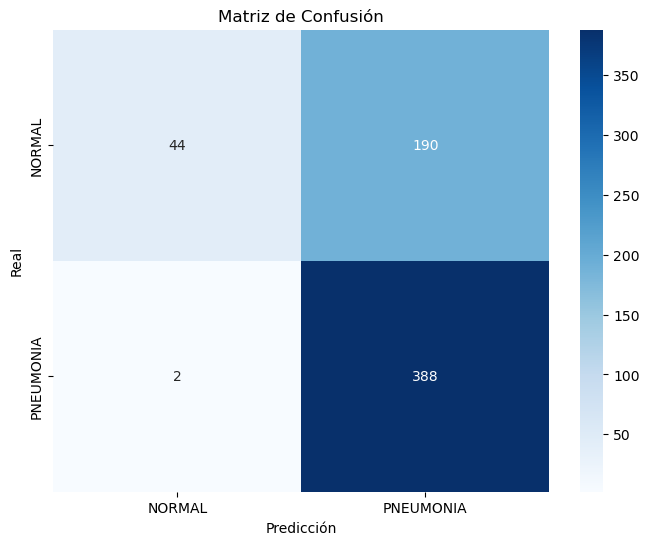

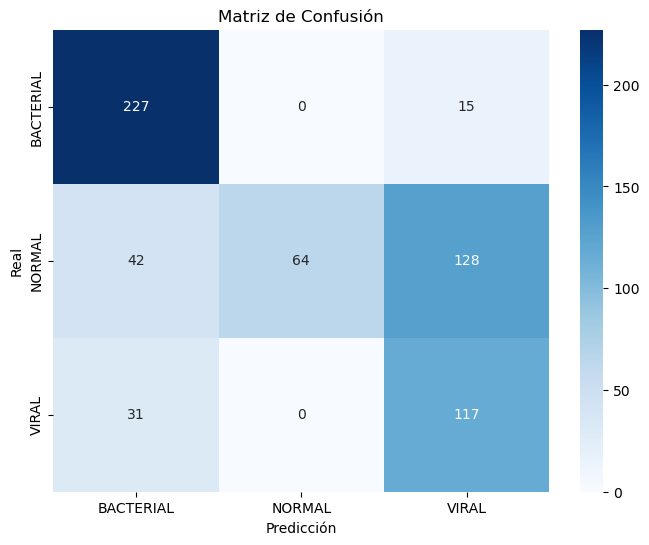

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def graficar_comparacion(model1_losses, model1_accuracies, model2_losses, model2_accuracies, epochs):
    # Gráfico de pérdidas
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), model1_losses, label="Pérdida Modelo 1", color='blue')
    plt.plot(range(1, epochs + 1), model2_losses, label="Pérdida Modelo 2", color='red', linestyle='dashed')
    plt.title("Pérdida de Entrenamiento durante el Entrenamiento")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.legend()
    plt.show()

    # Gráfico de precisión
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), model1_accuracies, label="Precisión Modelo 1", color='green')
    plt.plot(range(1, epochs + 1), model2_accuracies, label="Precisión Modelo 2", color='orange', linestyle='dashed')
    plt.title("Precisión durante el Entrenamiento")
    plt.xlabel("Época")
    plt.ylabel("Precisión (%)")
    plt.legend()
    plt.show()

def graficas_matriz_confusion(model, loader, device, clases):
    """
    Función para graficar la matriz de confusión de un modelo con cualquier número de clases.
    
    Parámetros:
    - model: El modelo de red neuronal entrenado.
    - loader: El dataloader con los datos de prueba o validación.
    - device: El dispositivo (CPU o GPU) donde está el modelo.
    - clases: Lista de nombres de las clases (por ejemplo, ['Normal', 'Pneumonía'] o ['Bacteriana', 'Viral', 'Normal']).
    """
    y_true = []
    y_pred = []
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Graficar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Usar esta función para los modelos
# Para el modelo de clasificación entre "NORMAL" y "PNEUMONÍA":
graficas_matriz_confusion(model_sano_enfermo, test_loader1, device, subcarpetas1)

# Para el modelo de clasificación entre varios tipos de neumonía:

graficas_matriz_confusion(model_tipos_pneumo, test_loader2, device, subcarpetas2)

###Cuestion 4

En el caso de que nos encontremos con una escasez de imágenes que posiblemente provoque overfitting en nuestro modelo, podemos utilizar varias técnicas. Es muy común en medicina verse afectado por este problema. 

Para resolverlo, vamos a utilizar el llamado 'Data Augmentation', que consiste en añadir más imágenes que simplemente son variaciones de las ya existentes. Se pueden girar, dar la vuelta, redimensionar o cambiar de color, con el fin de hacer creer al modelo que es una imagen nueva, reforzando así su capacidad de generalizar.

Vemos que, según los resultados sobre todo del primer modelo (Sano o Enfermo), los resultados son excesivamente perfectos, lo que puede significar que hemos caído en el overfitting. Para arreglar este problema, utilizaremos un transformador, para añadir más imágenes al dataset como ya hemos explicado anteriormente.

Si esta técnica no resulta efectiva, aplicaremos dropout, apagando aleatoriamente algunas neuronas durante el entrenamiento para lograr que el modelo aprenda "con un ojo tapado".